# <span style="color:blue">[</span> Lab 11-2 : MNIST and Deep learning CNN <span style="color:blue">]</span>
 <p>출처: <a href="http://hunkim.github.io/ml/" title="모두를 위한 머신러닝과 딥러닝의 강의" target="blank">모두를 위한 머신러닝과 딥러닝의 강의</a></p> <br/>
 > [CS 20SI: Tensorflow for Deep Learning Research](http://web.stanford.edu/class/cs20si/)

# Import Module

In [1]:
# Lab 11 MNIST and Deep learning CNN
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

# Step 1: Read in data
> using TF Learn's built in function to load MNIST data to the folder data/mnist <br/>
> Check out [MNIST For ML Beginners](https://www.tensorflow.org/get_started/mnist/beginners) for more information about the mnist dataset

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Step 2: Define paramaters for the model

In [3]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.set_random_seed(777)  # reproducibility

##### Step 3: create placeholders for features and labels
> each image in the MNIST data is of shape 28*28 = 784 <br/>
> therefore, each image is represented with a 1x784 tensor <br/>
> there are 10 classes for each image, corresponding to digits 0 - 9.  <br/>
> each lable is one hot vector. <br/>
> We'll be doing dropout for hidden layer so we'll need a placeholder for the dropout probability too <br/>
> Use None for shape so we can change the batch_size once we've built the graph <br/>
>> dropout (keep_prob) rate  0.5 ~ 0.7 on training, but should be 1 for testing

In [4]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# Step 4 + 5: create weights + do inference
> the model is <br/>
conv $\rightarrow$ relu $\rightarrow$ pool $\rightarrow$ dropOut  $\rightarrow$ <br/>
conv $\rightarrow$ relu $\rightarrow$ pool $\rightarrow$ dropOut  $\rightarrow$ <br/>
conv $\rightarrow$ relu $\rightarrow$ pool $\rightarrow$ dropOut $\rightarrow$  <br/>
relu $\rightarrow$ dropOut  $\rightarrow$  <br/>
fully connected $\rightarrow$ softmax


In [5]:
# ---------------------------------------------------------------
# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# ---------------------------------------------------------------
# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
'''

# ---------------------------------------------------------------
# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])

'''
Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
'''

# ---------------------------------------------------------------
# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
'''
Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''

# ---------------------------------------------------------------
# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))

logits = tf.matmul(L4, W5) + b5


'''
Tensor("add_1:0", shape=(?, 10), dtype=float32)
'''


'\nTensor("add_1:0", shape=(?, 10), dtype=float32)\n'

# Step 6: define loss function
> use softmax cross entropy with logits as the loss function
> compute mean cross entropy, softmax is applied internally

In [6]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

# Step 7: define training op
> using AdamOptimizer with learning rate of {learning_rate} to minimize cost

In [7]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize session & global variables

In [8]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train the model

In [9]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')


Learning started. It takes sometime.
Epoch: 0001 cost = 0.420728283
Epoch: 0002 cost = 0.093831111
Epoch: 0003 cost = 0.068687887
Epoch: 0004 cost = 0.057447360
Epoch: 0005 cost = 0.048385200
Epoch: 0006 cost = 0.043854826
Epoch: 0007 cost = 0.038436120
Epoch: 0008 cost = 0.038062397
Epoch: 0009 cost = 0.034725077
Epoch: 0010 cost = 0.031151260
Epoch: 0011 cost = 0.031648903
Epoch: 0012 cost = 0.029351540
Epoch: 0013 cost = 0.027477079
Epoch: 0014 cost = 0.028468259
Epoch: 0015 cost = 0.024895316
Learning Finished!


# Test the model and check accuracy

Accuracy: 0.9932
Label:  [2]
Prediction:  [2]


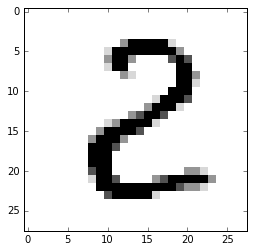

'\nLearning stared. It takes sometime.\nEpoch: 0001 cost = 0.385748474\nEpoch: 0002 cost = 0.092017397\nEpoch: 0003 cost = 0.065854684\nEpoch: 0004 cost = 0.055604566\nEpoch: 0005 cost = 0.045996377\nEpoch: 0006 cost = 0.040913645\nEpoch: 0007 cost = 0.036924479\nEpoch: 0008 cost = 0.032808939\nEpoch: 0009 cost = 0.031791007\nEpoch: 0010 cost = 0.030224456\nEpoch: 0011 cost = 0.026849916\nEpoch: 0012 cost = 0.026826763\nEpoch: 0013 cost = 0.027188021\nEpoch: 0014 cost = 0.023604777\nEpoch: 0015 cost = 0.024607201\nLearning Finished!\nAccuracy: 0.9938\n'

In [10]:
# Test model and check accuracy

# if you have a OOM error, please refer to lab-11-X-mnist_deep_cnn_low_memory.py
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={ X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))


# show image
plt.imshow(mnist.test.images[r:r + 1].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()


'''
Learning stared. It takes sometime.
Epoch: 0001 cost = 0.385748474
Epoch: 0002 cost = 0.092017397
Epoch: 0003 cost = 0.065854684
Epoch: 0004 cost = 0.055604566
Epoch: 0005 cost = 0.045996377
Epoch: 0006 cost = 0.040913645
Epoch: 0007 cost = 0.036924479
Epoch: 0008 cost = 0.032808939
Epoch: 0009 cost = 0.031791007
Epoch: 0010 cost = 0.030224456
Epoch: 0011 cost = 0.026849916
Epoch: 0012 cost = 0.026826763
Epoch: 0013 cost = 0.027188021
Epoch: 0014 cost = 0.023604777
Epoch: 0015 cost = 0.024607201
Learning Finished!
Accuracy: 0.9938
'''